In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import alexnet
from torchvision.utils import make_grid


# Configs

In [2]:
torch.manual_seed(42)
DEVICE = torch.device("mps")
torch.use_deterministic_algorithms(True)

## Create datasets

Hymenoptera dataset: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data

In [3]:
train_data = datasets.ImageFolder(
    "../data/hymenoptera_data/train",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.490, 0.449, 0.411], 
            [0.231, 0.221, 0.230]
        )
    ])
)

val_data = datasets.ImageFolder(
    "../data/hymenoptera_data/val",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.490, 0.449, 0.411], 
            [0.231, 0.221, 0.230]
        )
    ])
)

In [4]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True)

In [5]:
len(train_data), len(val_data)

(244, 153)

In [6]:
classes = train_data.classes
classes

['ants', 'bees']

## Visualise some examples

In [7]:
def image_show(img: torch.Tensor, y: torch.Tensor, figsize: tuple[int, int] =(10, 10)):
    """
    Display an image with its corresponding label.

    Args:
        img: The image tensor to be displayed.
        y: The label(s) corresponding to the image.
        figsize: The size of the figure. Defaults to (10, 10).
    """
    pass
    np_img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    np_img = stddev * np_img + avg
    np_img = np.clip(np_img, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(np_img)
    plt.title([classes[i] for i in y])



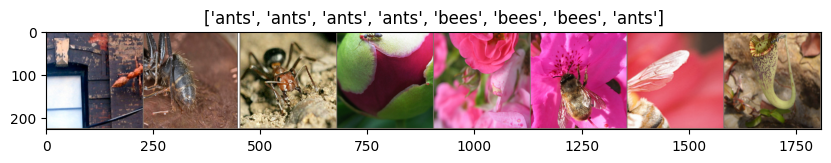

In [8]:
X, y = next(iter(train_dataloader))

image_show(make_grid(X, nrow=8), y)

## Pre-trained model

In [9]:
alexnet_pretrained = alexnet(weights="DEFAULT")

In [10]:
alexnet_pretrained.classifier[6] = nn.Linear(4096, 2)
alexnet_pretrained

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
loss_fn = nn.CrossEntropyLoss()
optim = SGD(alexnet_pretrained.parameters(), lr=0.0001)

In [12]:
train_losses =[]
val_losses =[]
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    # Train
    alexnet_pretrained.train()
    train_loss = 0.0
    train_correct = 0.0
    train_total = 0.0
    
    for (X_train, y_train) in train_dataloader:
        alexnet_pretrained.to(DEVICE)
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
        
        
        # Zero the parameter gradients
        optim.zero_grad()
        
        # Forward pass
        y_pred = alexnet_pretrained(X_train)
        train_batch_loss = loss_fn(y_pred, y_train)
        
        # Backward pass and optimization
        train_batch_loss.backward()
        optim.step()
        
        train_loss += train_batch_loss.item()
        
        _, class_pred = torch.max(y_pred, 1)
        train_total += y_train.size(0)
        train_correct += (class_pred == y_train).sum().item()
    
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_correct / train_total)
    
    # Validation
    alexnet_pretrained.eval()
    val_loss = 0.0
    val_correct = 0.0
    val_total = 0.0
    
    with torch.no_grad():
        for (X_val, y_val) in val_dataloader:
            alexnet_pretrained.to(DEVICE)
            X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
            
            # Forward pass
            y_pred_val = alexnet_pretrained(X_val)
            val_batch_loss = loss_fn(y_pred_val, y_val)
            
            val_loss += val_batch_loss.item()
            
            _, class_pred = torch.max(y_pred_val, 1)
            val_total += y_val.size(0)
            val_correct += (class_pred == y_val).sum().item()
            
    val_losses.append(val_loss/len(val_dataloader))
    val_accuracies.append(val_correct / val_total)

Text(0, 0.5, 'Accuracy')

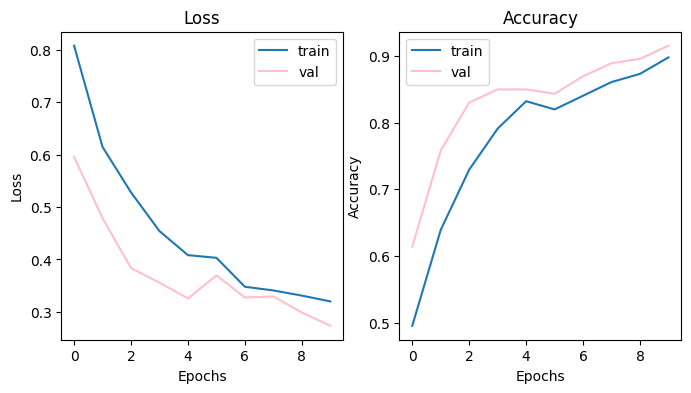

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))


sns.lineplot(x=range(num_epochs), y=train_losses, ax=axs[0], label="train")
sns.lineplot(x=range(num_epochs), y=val_losses, ax=axs[0], color="pink", label="val")

axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

sns.lineplot(x=range(num_epochs), y=train_accuracies, ax=axs[1], label="train")
sns.lineplot(x=range(num_epochs), y=val_accuracies, ax=axs[1], color="pink", label="val")

axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")


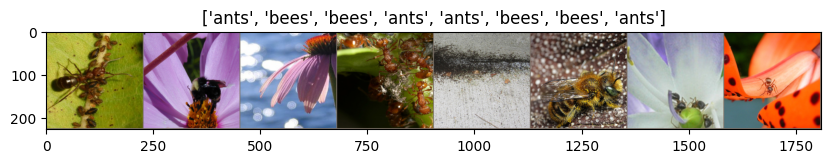

In [72]:
# Ensure the model is on the correct device
alexnet_pretrained.to(DEVICE)

# Get a batch of validation data
inputs, labels = next(iter(val_dataloader))
inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

# Perform inference
outputs = alexnet_pretrained(inputs)
_, predicted_classes = torch.max(outputs, 1)

# Move predictions and inputs to CPU for visualization
predicted_classes = predicted_classes.cpu().numpy()
inputs_cpu = inputs.cpu()

# Display the images with their predicted classes
image_show(make_grid(inputs_cpu, nrow=8), predicted_classes)